In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def df_corr_columns(df, target, threshold):
    df_corr = df.corr()
    df_corr_SalePrice = df_corr[[target]]
    df_corr_SalePrice = df_corr_SalePrice.reset_index()
    df_corr_SalePrice = df_corr_SalePrice[(df_corr_SalePrice['index'] != target)]
    df_corr_SalePrice_columns = df_corr_SalePrice[(
        (df_corr_SalePrice[target] > threshold) | 
        (df_corr_SalePrice[target] < -threshold))]['index']
    return df_corr_SalePrice_columns

In [3]:
def separe_per_unique_threshold(df, threshold):
    dic_c_unique_len = {}
    for c in df.columns:
        dic_c_unique_len[c] = len(df[c].unique())
        #print(c, len(df_num[c].unique()))
 

    df_c_unique_len = pd.DataFrame.from_dict(dic_c_unique_len, orient="index").reset_index()
    df_c_unique_len.columns=['variable', 'count']
    return df_c_unique_len[df_c_unique_len['count'] <= 20].sort_values('count'), df_c_unique_len[df_c_unique_len['count'] > 20].sort_values('count')


In [4]:
def dummies(df, quantiles = 4):
    
    columns = df.columns
    for c in columns:
        
        df[c] = pd.qcut(df[c], q=quantiles, duplicates='drop') # , labels=dummies_cols
        
        df = pd.concat([df, pd.get_dummies(df[c], prefix=c)], axis=1)
        
    df.columns = [c.replace(',', '_') for c in df.columns]
    df.columns = [c.replace('(', '_') for c in df.columns]
    df.columns = [c.replace(']', '_') for c in df.columns]
    df.columns = [c.replace('.', '_') for c in df.columns]
           
        
    df.drop(columns, axis=1, inplace=True)
        
    return df

In [5]:
corr_threshold = 0
dummies_quantiles = 4
variance_threshold = 0.1
unique_values_threshold = 20
pca_components = 0.999


In [6]:
df_train = pd.read_csv("./dataset/train.csv")

df_train_Id = df_train[['Id']]


##### Outliers

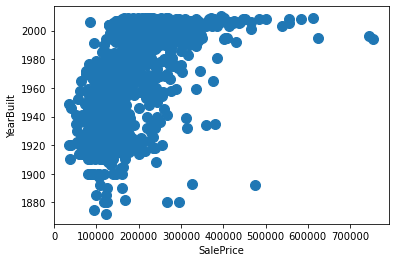

In [7]:
df_train.plot.scatter(x = 'SalePrice', y = 'YearBuilt', s = 100); # , figsize=(10, 5)

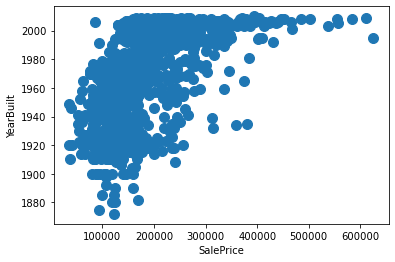

In [8]:
df_train.drop(df_train[(df_train['YearBuilt'] < 1900) & (df_train['SalePrice'] > 250000)].index, inplace=True)
df_train.drop(df_train[(df_train['YearBuilt'] > 1980) & (df_train['SalePrice'] > 700000)].index, inplace=True)
#df_train.drop(df_train[(df_train['YearBuilt'] < 1900) & (df_train['SalePrice'] == 10)].index, inplace=True)
df_train.plot.scatter(x = 'SalePrice', y = 'YearBuilt', s = 100);

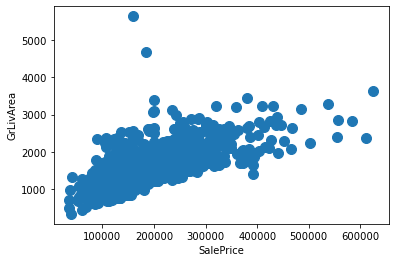

In [9]:
df_train.plot.scatter(x = 'SalePrice', y = 'GrLivArea', s = 100);

In [10]:
df_train.drop(df_train[(df_train['GrLivArea'] > 4000)].index, inplace=True)

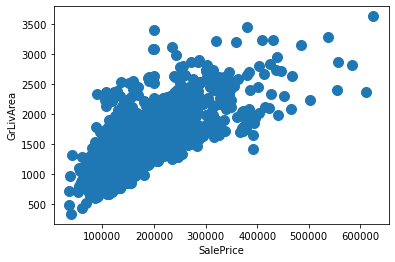

In [11]:
df_train.plot.scatter(x = 'SalePrice', y = 'GrLivArea', s = 100);

In [12]:
df_train_SalePrice = df_train[['SalePrice']]
df_train.drop(['Id'], axis=1, inplace=True)
df_train.shape

(1452, 80)

In [13]:
df_test = pd.read_csv("./dataset/test.csv")
df_test_Id = df_test[['Id']]
df_test.drop(['Id'], axis = 1, inplace=True)
df_test.shape

(1459, 79)

##### Concat train and test to process all datas

In [14]:
df_train = pd.concat([df_train, df_test])
df_train.shape

(2911, 80)

##### Fill the nan

In [15]:
df_train_num =  df_train.select_dtypes(include='number')
df_train_num.fillna(df_train_num.median(), inplace=True)


df_train_cat = df_train.select_dtypes(include='object')
df_train_cat.fillna(df_train_cat.mode().iloc[0], inplace=True)

df_train = pd.concat([df_train_num, df_train_cat], axis=1)

print(df_train_num.shape, df_train_cat.shape, df_train.shape)

(2911, 37) (2911, 43) (2911, 80)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### Matrice de correlation

In [16]:
df_train = df_train[df_corr_columns(df_train, 'SalePrice', corr_threshold)]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2911 entries, 0 to 1458
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2911 non-null   int64  
 1   LotFrontage    2911 non-null   float64
 2   LotArea        2911 non-null   int64  
 3   OverallQual    2911 non-null   int64  
 4   OverallCond    2911 non-null   int64  
 5   YearBuilt      2911 non-null   int64  
 6   YearRemodAdd   2911 non-null   int64  
 7   MasVnrArea     2911 non-null   float64
 8   BsmtFinSF1     2911 non-null   float64
 9   BsmtFinSF2     2911 non-null   float64
 10  BsmtUnfSF      2911 non-null   float64
 11  TotalBsmtSF    2911 non-null   float64
 12  1stFlrSF       2911 non-null   int64  
 13  2ndFlrSF       2911 non-null   int64  
 14  LowQualFinSF   2911 non-null   int64  
 15  GrLivArea      2911 non-null   int64  
 16  BsmtFullBath   2911 non-null   float64
 17  BsmtHalfBath   2911 non-null   float64
 18  FullBath

In [17]:
df_train_dummies_cols, df_train_scaled_cols = separe_per_unique_threshold(df_train, unique_values_threshold)
print(df_train_dummies_cols.shape, df_train_scaled_cols.shape)

(15, 2) (21, 2)


##### transfert à la main de certaines variables pour discretisation

In [18]:
df_train_dummies_cols = pd.concat([df_train_dummies_cols, df_train_scaled_cols[
    (df_train_scaled_cols['variable'] == 'YearBuilt') |
    (df_train_scaled_cols['variable'] == 'YearRemodAdd') |
    (df_train_scaled_cols['variable'] == 'GarageYrBlt')]])


df_train_scaled_cols = df_train_scaled_cols[
    (df_train_scaled_cols['variable'] != 'YearBuilt') &
    (df_train_scaled_cols['variable'] != 'YearRemodAdd') &
    (df_train_scaled_cols['variable'] != 'GarageYrBlt')]



In [19]:
df_train_dummies_cols

,variable,count
17,BsmtHalfBath,3
19,HalfBath,3
16,BsmtFullBath,4
21,KitchenAbvGr,4
18,FullBath,5
23,Fireplaces,5
35,YrSold,5
25,GarageCars,6
20,BedroomAbvGr,8
4,OverallCond,9


In [20]:
df_train_scaled_cols

,variable,count
30,3SsnPorch,31
14,LowQualFinSF,35
33,MiscVal,38
31,ScreenPorch,120
1,LotFrontage,128
29,EnclosedPorch,182
28,OpenPorchSF,248
9,BsmtFinSF2,272
27,WoodDeckSF,378
7,MasVnrArea,441


### Dummies

In [21]:
df_train_dummies = dummies(df_train[df_train_dummies_cols['variable'].tolist()])

df_train_dummies.head()

<ipython-input-4-8fc706ab67e0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = pd.qcut(df[c], q=quantiles, duplicates='drop') # , labels=dummies_cols


,BsmtHalfBath__-0_001_ 2_0_,HalfBath__-0_001_ 1_0_,HalfBath__1_0_ 2_0_,BsmtFullBath__-0_001_ 1_0_,BsmtFullBath__1_0_ 3_0_,KitchenAbvGr__-0_001_ 1_0_,KitchenAbvGr__1_0_ 3_0_,FullBath__-0_001_ 1_0_,FullBath__1_0_ 2_0_,FullBath__2_0_ 4_0_,...,YearRemodAdd__1993_0_ 2004_0_,YearRemodAdd__2004_0_ 2010_0_,GarageYrBlt__1894_999_ 1961_0_,GarageYrBlt__1961_0_ 1979_0_,GarageYrBlt__1979_0_ 2001_0_,GarageYrBlt__2001_0_ 2207_0_,YearBuilt__1871_999_ 1954_0_,YearBuilt__1954_0_ 1973_0_,YearBuilt__1973_0_ 2001_0_,YearBuilt__2001_0_ 2010_0_
0,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,1,1,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
3,1,1,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


### Scaled

In [22]:
df_train_scaled = df_train[df_train_scaled_cols['variable'].tolist()]

scaler = preprocessing.StandardScaler().fit(df_train_scaled)
df_train_scaled[df_train_scaled.columns] = pd.DataFrame(scaler.transform(df_train_scaled), index=df_train_scaled.index)

df_train_scaled.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,3SsnPorch,LowQualFinSF,MiscVal,ScreenPorch,LotFrontage,EnclosedPorch,OpenPorchSF,BsmtFinSF2,WoodDeckSF,MasVnrArea,GarageArea,2ndFlrSF,BsmtFinSF1,TotalBsmtSF,1stFlrSF,BsmtUnfSF,GrLivArea,LotArea
0,-0.103474,-0.099696,-0.089716,-0.286275,-0.189292,-0.360063,0.209400,-0.293462,-0.738938,0.538113,0.356719,1.227949,0.603810,-0.448980,-0.782325,-0.932996,0.443045,-0.214575
1,-0.103474,-0.099696,-0.089716,-0.286275,0.533844,-0.360063,-0.707690,-0.293462,1.617934,-0.569040,-0.054343,-0.785512,1.218183,0.500077,0.275230,-0.627798,-0.475947,-0.067230
2,-0.103474,-0.099696,-0.089716,-0.286275,-0.044665,-0.360063,-0.076251,-0.293462,-0.738938,0.346056,0.636989,1.256241,0.106891,-0.299375,-0.615616,-0.286158,0.598945,0.144178
3,-0.103474,-0.099696,-0.089716,-0.286275,-0.430338,3.892679,-0.181491,-0.293462,-0.738938,-0.569040,0.795808,0.996896,-0.502964,-0.682738,-0.508819,-0.044732,0.457404,-0.073636
4,-0.103474,-0.099696,-0.089716,-0.286275,0.726680,-0.360063,0.555188,-0.293462,0.779584,1.408018,1.702013,1.697128,0.488616,0.226581,-0.029533,-0.158612,1.444089,0.529839


In [23]:
df_train = pd.concat([df_train_dummies, df_train_scaled], axis=1)
df_train.shape

(2911, 71)

##### variance filter

In [24]:
'''
selector = VarianceThreshold(variance_threshold)

selector.fit(df_train)
features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
#features
features = [column for column in df_train.columns[features]] #Array of all nonremoved features' names
#features
#Format and Return
df_train = pd.DataFrame(selector.transform(df_train))
df_train.columns = features
'''

"\nselector = VarianceThreshold(variance_threshold)\n\nselector.fit(df_train)\nfeatures = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features\n#features\nfeatures = [column for column in df_train.columns[features]] #Array of all nonremoved features' names\n#features\n#Format and Return\ndf_train = pd.DataFrame(selector.transform(df_train))\ndf_train.columns = features\n"

##### separate train - test

In [25]:
df_test = df_train.tail(1459) 
df_train = df_train.head(df_train_SalePrice.shape[0]) # shape minus outliers 

print(df_train.shape, df_test.shape)

(1452, 71) (1459, 71)


In [26]:
target = df_train_SalePrice
data = df_train



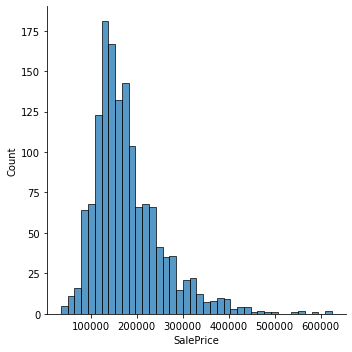

In [27]:
sns.displot(target['SalePrice']);

In [28]:
target = np.log1p(target['SalePrice'])

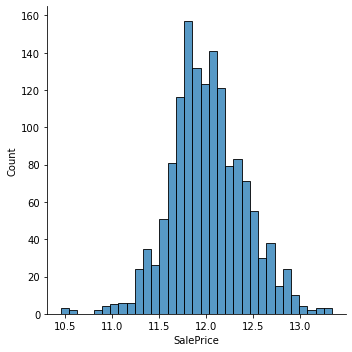

In [29]:
sns.displot(target);

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state = 66) 

##### pca reduction dimension

In [31]:
'''
print(X_train.shape, X_test.shape)
pca = PCA(n_components = pca_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape)
'''

'\nprint(X_train.shape, X_test.shape)\npca = PCA(n_components = pca_components)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)\nprint(X_train.shape, X_test.shape)\n'

In [32]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
print(xgboost.__version__)

1.5.2


### XGBRegressor

https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
    
https://stackoverflow.com/questions/53731529/using-xgboost-regressor-in-python-results-in-very-good-training-performance-but

In [33]:
# create an xgboost regression model
#model_xgbr = XGBRegressor()

# Instantiation
xgb_r = XGBRegressor(objective ='reg:squarederror', learning_rate=0.3, subsample=1, colsample_bytree=1, gamma=0.1,
                     max_depth=4, 
                  n_estimators = 50, seed = 123)
  
# Fitting the model
eval_set = [(X_test, y_test)]
xgb_r.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)
  
# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:8.07420
[1]	validation_0-rmse:5.66032
[2]	validation_0-rmse:3.97081
[3]	validation_0-rmse:2.79216
[4]	validation_0-rmse:1.96498
[5]	validation_0-rmse:1.38767
[6]	validation_0-rmse:0.98425
[7]	validation_0-rmse:0.70529
[8]	validation_0-rmse:0.51504
[9]	validation_0-rmse:0.38472
[10]	validation_0-rmse:0.29803
[11]	validation_0-rmse:0.24170
[12]	validation_0-rmse:0.20691
[13]	validation_0-rmse:0.18701
[14]	validation_0-rmse:0.17526
[15]	validation_0-rmse:0.16891
[16]	validation_0-rmse:0.16433
[17]	validation_0-rmse:0.16284
[18]	validation_0-rmse:0.16146
[19]	validation_0-rmse:0.16087
[20]	validation_0-rmse:0.15955
[21]	validation_0-rmse:0.15948
[22]	validation_0-rmse:0.15945
[23]	validation_0-rmse:0.15944
[24]	validation_0-rmse:0.15943
[25]	validation_0-rmse:0.15943
[26]	validation_0-rmse:0.15943
[27]	validation_0-rmse:0.15943
[28]	validation_0-rmse:0.15943
[29]	validation_0-rmse:0.15943
[30]	validation_0-rmse:0.15943
[31]	validation_0-rmse:0.15943
[32]	validation_0-

In [34]:
print("score train :",xgb_r.score(X_train, y_train))
print("score test :", xgb_r.score(X_test, y_test))

score train : 0.9183019213510287
score test : 0.8404477283143668


In [35]:
#pred = xgb_r.predict(pca.transform(df_test))
pred = xgb_r.predict(df_test)

df_pred = pd.DataFrame(np.expm1(pred), columns=['SalePrice'])
df_pred.head()

,SalePrice
0,117208.101562
1,165390.296875
2,170773.218750
3,181106.640625
4,200937.359375


In [36]:
df_pred = df_test_Id.join(df_pred)

df_pred.shape

(1459, 2)

In [37]:
df_pred.to_csv('./submission/model_xgb_r.csv', index=False)

### GradientBoostingRegressor

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

In [39]:
gbrt = GradientBoostingRegressor(max_depth=4, n_estimators = 5000, learning_rate=0.1, verbose=True)

In [40]:
gbrt.fit(X_train, y_train.values.ravel())

      Iter       Train Loss   Remaining Time 
         1           0.1314           43.54s
         2           0.1128           35.98s
         3           0.0971           42.25s
         4           0.0844           31.68s
         5           0.0736           32.84s
         6           0.0643           34.03s
         7           0.0566           34.16s
         8           0.0502           35.53s
         9           0.0449           32.61s
        10           0.0400           32.61s
        20           0.0177           30.13s
        30           0.0114           27.81s
        40           0.0091           27.91s
        50           0.0079           28.10s
        60           0.0069           28.43s
        70           0.0062           27.62s
        80           0.0056           28.50s
        90           0.0052           28.62s
       100           0.0047           27.64s
       200           0.0021           28.29s
       300           0.0011           27.67s
       40

GradientBoostingRegressor(max_depth=4, n_estimators=5000, verbose=True)

In [41]:
pred = gbrt.predict(X_test)

In [42]:
gbrt.score(X_test, y_test)

0.8602120560255018

In [43]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.149225


In [44]:
df_pred.to_csv('./submission/model_gbrt.csv', index=False)

##### tests

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

###### learning_rates

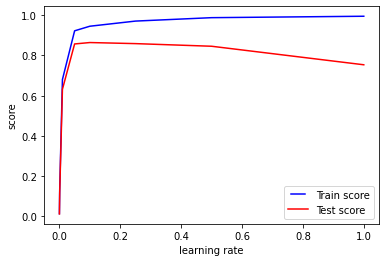

In [45]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingRegressor(learning_rate=eta)
   model.fit(X_train, y_train.values.ravel())
   train_pred = model.predict(X_train)
   train_results.append(model.score(X_train, y_train.values.ravel()))
   y_pred = model.predict(X_test)
   test_results.append(model.score(X_test, y_test))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train score")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("score")
plt.xlabel("learning rate")
plt.show()

###### n_estimators

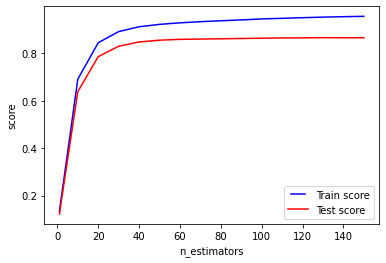

In [46]:
n_estimators = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
train_results = []
test_results = []
for eta in n_estimators:
   model = GradientBoostingRegressor(n_estimators=eta)
   model.fit(X_train, y_train.values.ravel())
   train_pred = model.predict(X_train)
   train_results.append(model.score(X_train, y_train.values.ravel()))
   y_pred = model.predict(X_test)
   test_results.append(model.score(X_test, y_test))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train score")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.show()